# Figure 3
## Partial   dependence plots showing the marginal effect of each predictor on the probability of daily HIPE occurrence, based on a Generalized Additive Model (GAM).   

In [1]:
## ---- Libraries and custom functions --------------------------------------
library(terra)
library(tidyverse)
library(pdp)
library(mgcv)
library(mgcViz)
library(gratia)
library(patchwork)
setwd("/mnt/CEPH_PROJECTS/HIPEAtMount/HIPEAtMount-WP1")
source("Script/Functions/theme_plot.R")
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 200)

terra 1.8.60

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks terra::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘pdp’


The following object is masked from ‘package:purrr’:

    partial


Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.

Loading required package: qgam

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Registered S3 me

Rows: 1364 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (4): A, m, m_log, M
date (1): time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


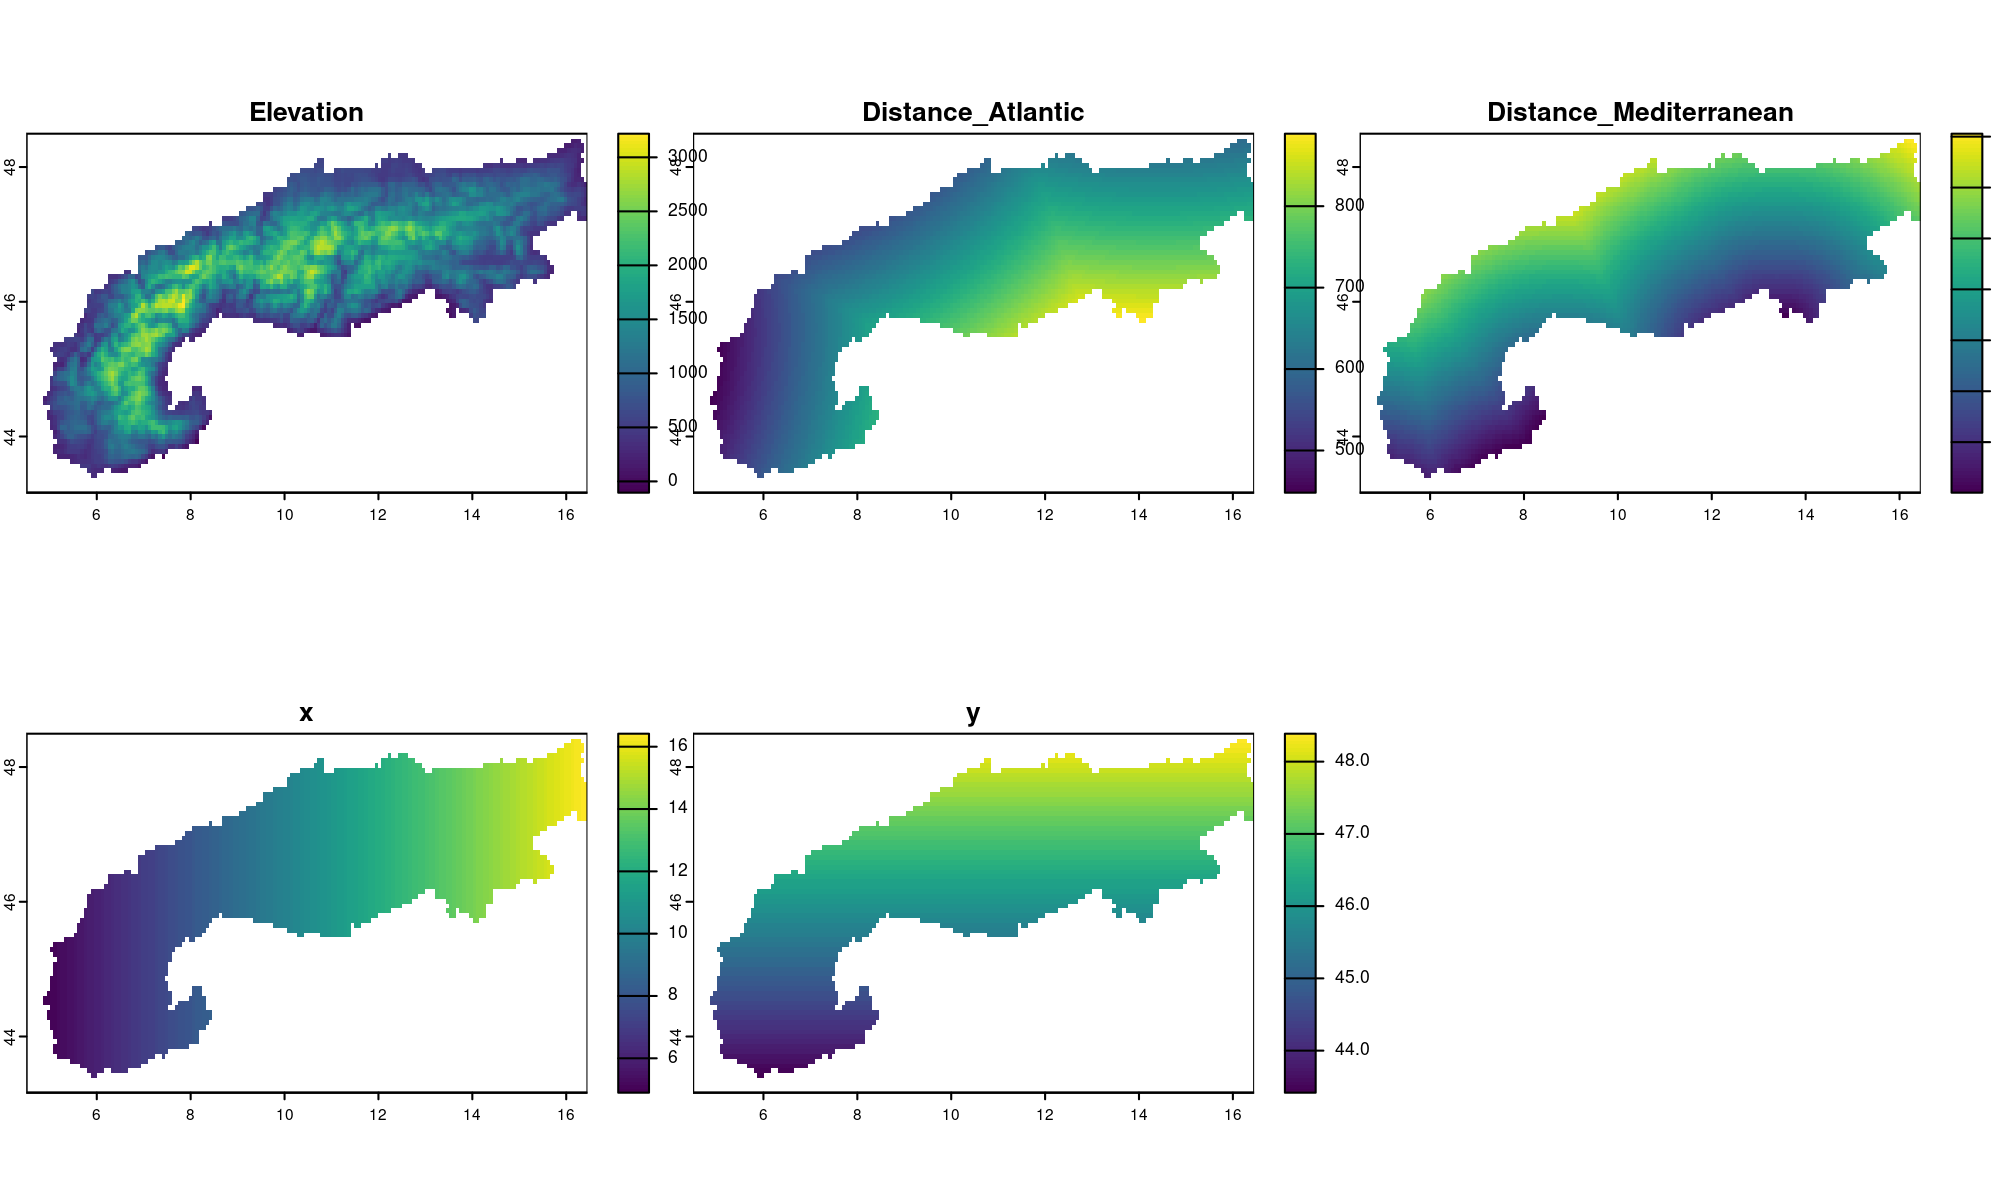

Joining with `by = join_by(lat, lon)`


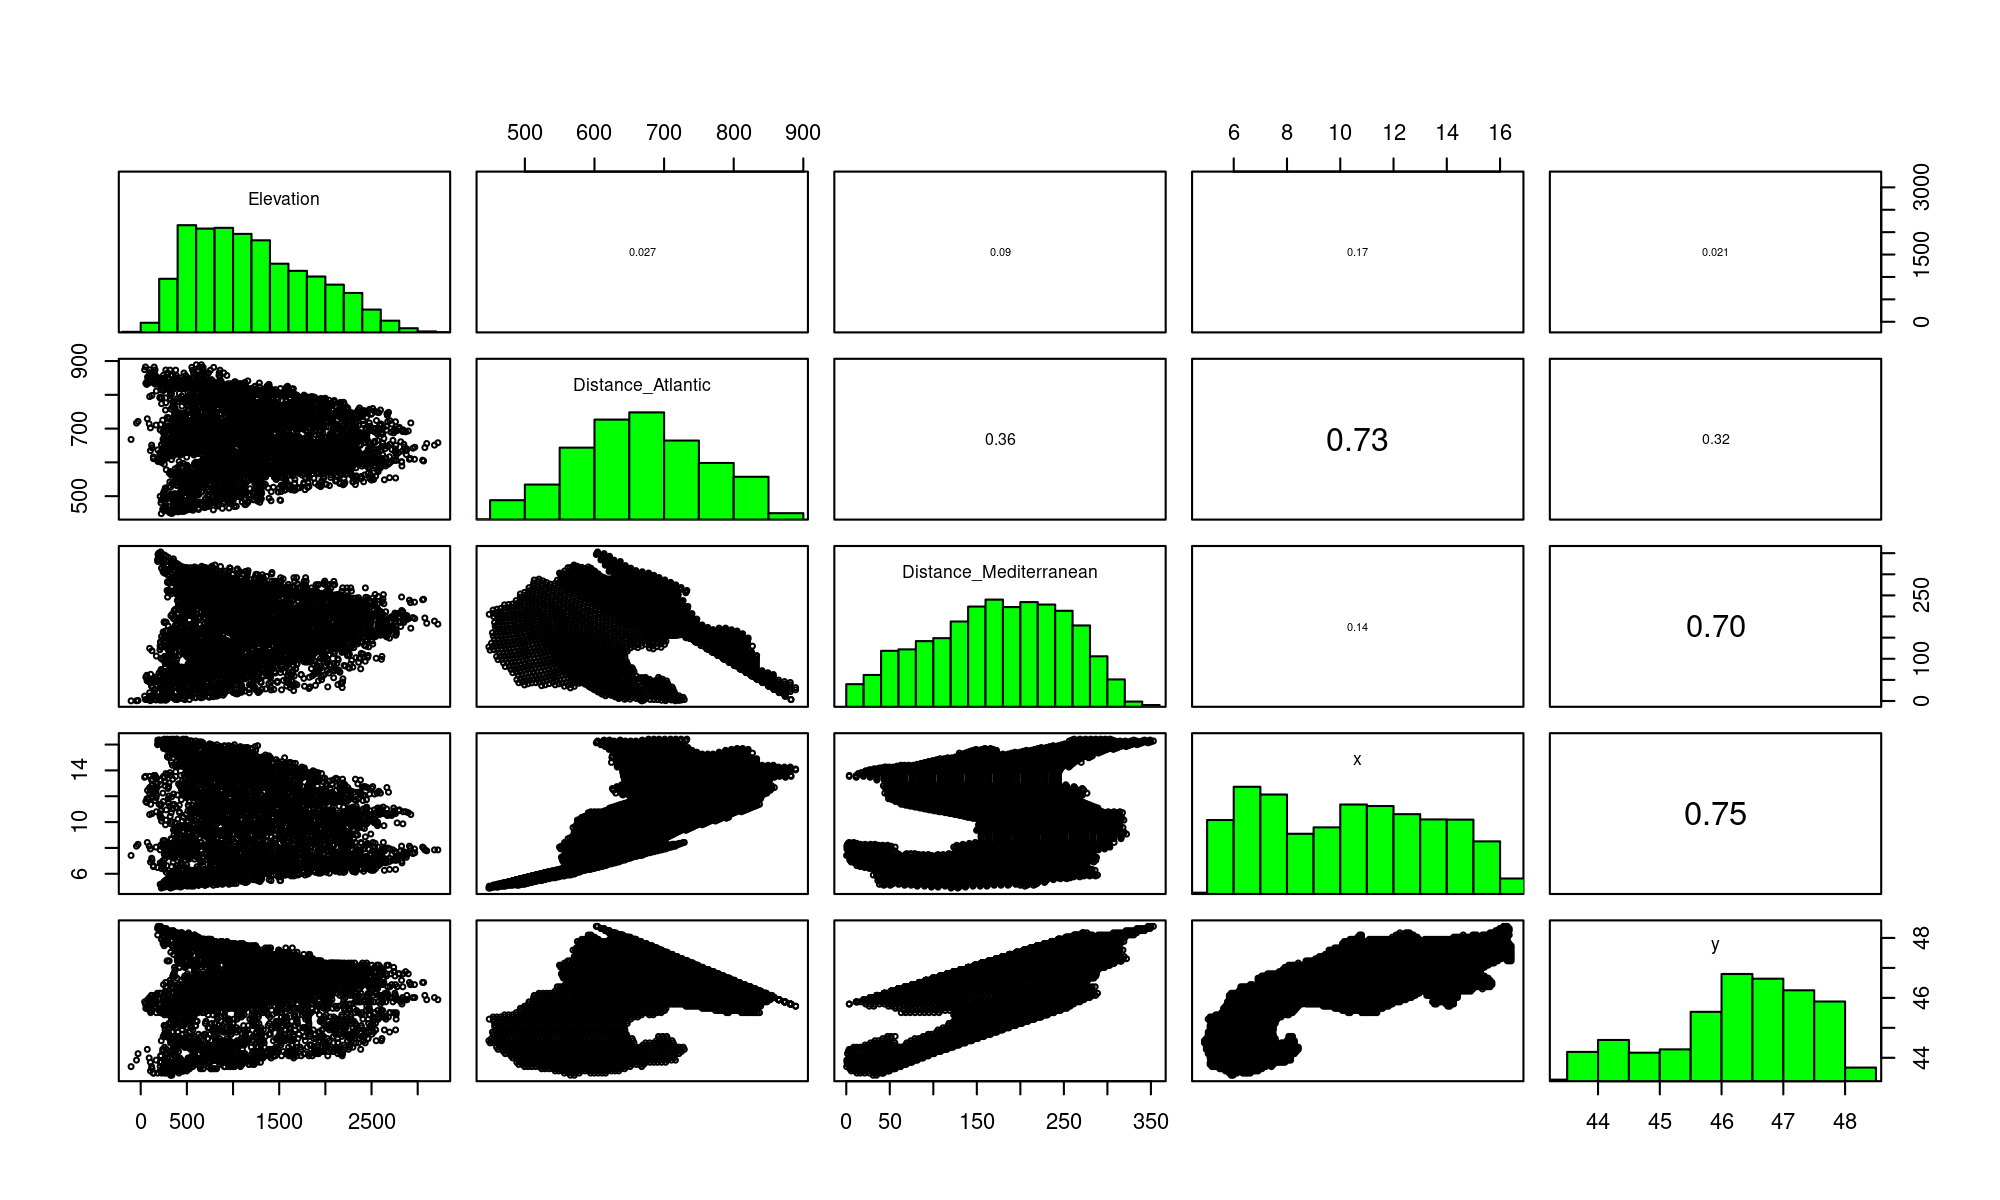

In [3]:
## ---- Preparing predictors and predictand ----------------------------------

# Loading HIPEs (!!! single days !!!)
ACPD_HIPE<- read_csv("Output/Data/2_ranking_databases/ACPD_complete_ranking/ACPD_HIPE_Ranking_1961-2022.csv")

# Merge temporal and spatial data -----------------------------------------
grids <- list.files("Output/Data/3_Predictors/Spatial/", pattern = "*.tif", full.names = T) %>%
  rast()

grids$Distance_Mediterranean <- grids$Distance_Mediterranean/1000
grids$Distance_Atlantic <- grids$Distance_Atlantic/1000

# include lat and lon in grids
lon <- terra::init(grids,"x") %>% project(grids) %>% mask(grids$Elevation)
names(lon) <- "x"
lat <- terra::init(grids,"y")%>% project(grids) %>% mask(grids$Elevation)
names(lat) <- "y"

grids <- c(grids)
lonlat <- c(lon, lat)

sp_predictors <- as.data.frame(grids, xy = T) %>% as_tibble() %>% rename(lon = x, lat = y) %>%
  bind_cols(as.data.frame(lonlat))

# Plot predictors
c(grids[[c(1,3,4)]], lonlat) %>% plot
# c(grids[[c(1,3,4)]], lonlat) %>% terra::pairs() # To check correlation between predictors

# Combining predictors with HIPEs
all_data <- read_rds("Output/Data/3_Predictors/Temporal/predictand_predictors_temp.rds") %>%
  filter(time %in% ACPD_HIPE$time) %>%
  ungroup() %>%
  select(-P_H,-Thr) %>%
  inner_join(sp_predictors) %>% 
  # arrange(all_data, time) %>%
  filter(time >= "1961-01-01") %>%
  mutate(year = year(time)) %>%
  select(-days_between_EPEs) %>% 
 
  na.omit()

   user  system elapsed 
 29.490  22.135  27.228 


Family: binomial 
Link function: logit 

Formula:
EPE_detection ~ s(doy, bs = "cc", k = 5) + s(Elevation, k = 5) + 
    s(Distance_Mediterranean, bs = "tp", k = 5) + s(Distance_Atlantic, 
    k = 5) + ti(doy, Distance_Mediterranean, bs = c("cc", "tp"), 
    k = c(5, 5))

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.06701    0.01538  -329.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                                  edf Ref.df  Chi.sq p-value    
s(doy)                          2.994  3.000  2146.0  <2e-16 ***
s(Elevation)                    3.836  3.983   444.8  <2e-16 ***
s(Distance_Mediterranean)       3.926  3.996  2711.1  <2e-16 ***
s(Distance_Atlantic)            3.997  4.000  2234.3  <2e-16 ***
ti(doy,Distance_Mediterranean) 11.859 12.000 11492.5  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.00649   Devi

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = all_data$EPE_detection, predictor = all_data$fit,     auc = T)

Data: all_data$fit in 6297285 controls (all_data$EPE_detection 0) < 55763 cases (all_data$EPE_detection 1).
Area under the curve: 0.7087

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


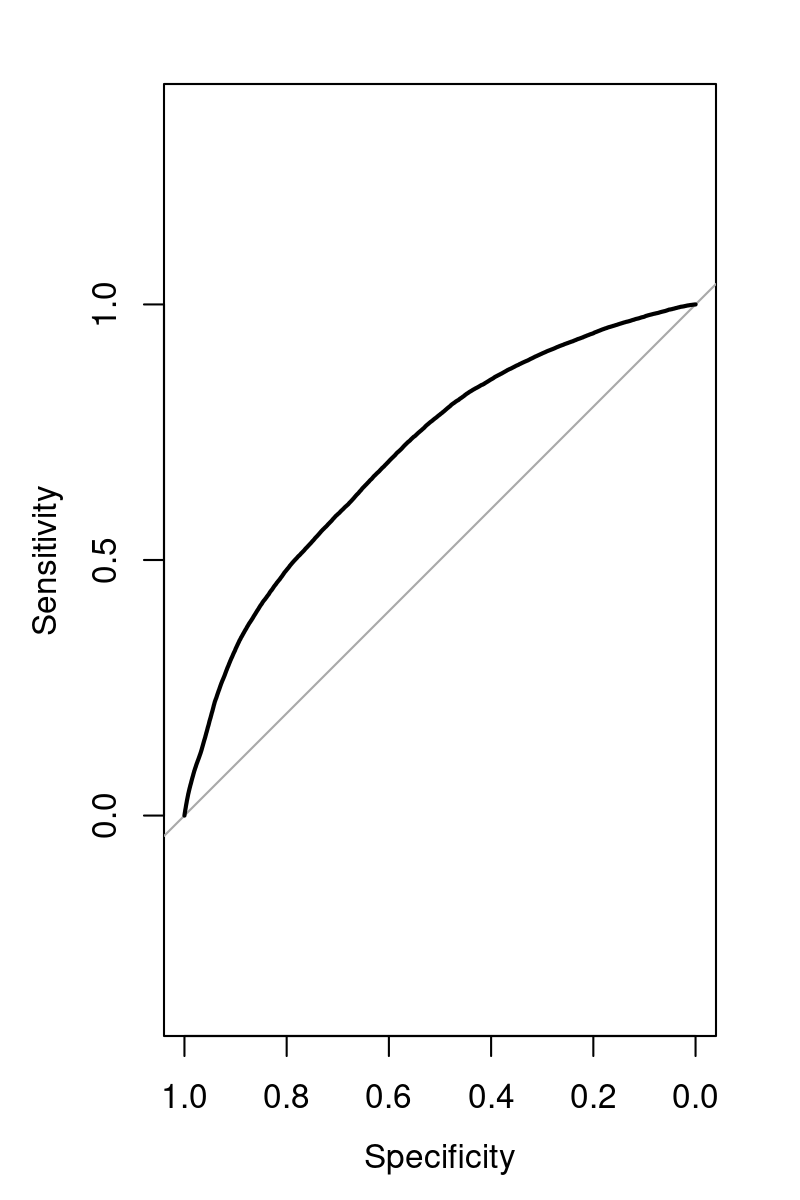

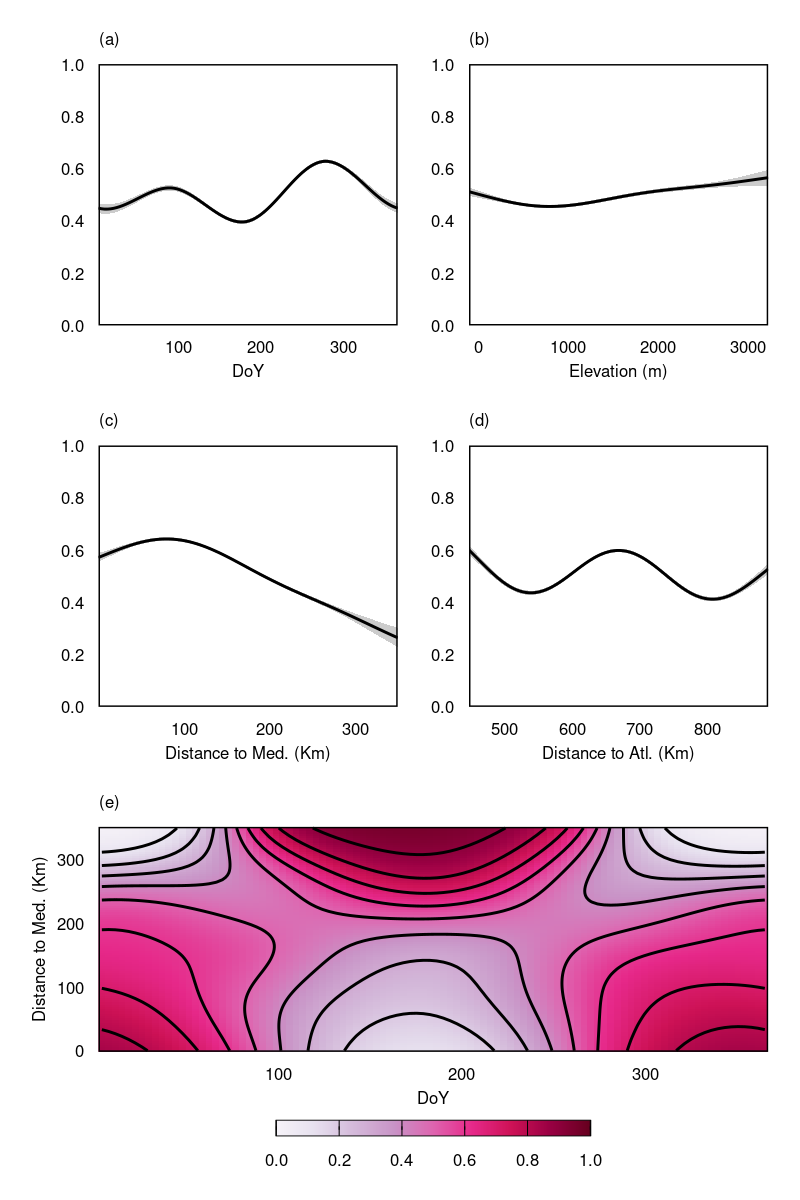

In [5]:
options(repr.plot.width = 4, repr.plot.height = 6, repr.plot.res = 200)

# Formula to be parsed
formula <- EPE_detection ~ 
  s(doy, bs = "cc", k = 5) +
  s(Elevation, k = 5) +
  s(Distance_Mediterranean, bs = "tp", k = 5) +
  s(Distance_Atlantic, k = 5) +
  ti(doy,Distance_Mediterranean, bs = c("cc", "tp"), k = c(5, 5))
formula <- as.formula(formula)

# Model fit
system.time(fit <- mgcv::bam(formula, data=all_data, family=binomial, method = "fREML", discrete=100, exclude = NA))

# Model's summary
summary(fit)

# Predicting the response
all_data$fit <- predict(fit, type="response", exclude = NA)

# ROC AUC
roc_curve <- pROC::roc(response = all_data$EPE_detection, predictor = all_data$fit, auc = T);plot(roc_curve)
roc_curve

# Run all the smooth terms and generate a plot
smooth_vars = c("s(doy)", "s(Elevation)",  
                "s(Distance_Mediterranean)", "s(Distance_Atlantic)")
vars = c("doy", "Elevation", "Distance_Mediterranean", "Distance_Atlantic")
names = c("DoY", "Elevation (m)", "Distance to Med. (Km)", "Distance to Atl. (Km)")
subtitle = c("(a)", "(b)", "(c)", "(d)")
plot_l <- list()

for (ii in seq_along(vars)) {
  
plot_l[[ii]]  <- draw(filter(smooth_estimates(fit), .smooth == smooth_vars[ii]), fun = inv_link(fit))+
  scale_y_continuous(limits = c(0,1), breaks = seq(0,1,0.2),expand = c(0,0)) +
  scale_x_continuous(expand = c(0,0),breaks =scales::pretty_breaks(4)) +
  labs(x = names[ii],
       subtitle = subtitle[ii]) +
  theme_4paper2+
  theme(axis.title.y = element_blank(),
        plot.title = element_blank(),
        plot.caption = element_blank(),
        legend.title = element_blank(),
        legend.text = element_text(size = 6),
        axis.title.x = element_text(size = 6),
        plot.subtitle = element_text(size = 6),
        axis.text = element_text(size = 6),
        legend.position = "bottom")

}

# Plotting the interaction between DoY and the distance to Mediterranean
interaction <- draw(filter(smooth_estimates(fit), .smooth == "ti(doy,Distance_Mediterranean)"), fun = inv_link(fit))+
  scale_y_continuous(expand = c(0,0),breaks =scales::pretty_breaks(4)) +
  scale_x_continuous(expand = c(0,0),breaks =scales::pretty_breaks(4)) +
  labs(x = "DoY",
       y = "Distance to Med. (Km)",
       subtitle = "(e)") +
  guides(fill = guide_colorbar( # posar llgenda a sota
    title = "mm",
    title.position = "top",
    barwidth = unit(4, "cm"),
    barheight = unit(.2, "cm"),
    frame.linewidth = 0.15,
    frame.colour = "black",
    ticks.colour = "black")) +
  scale_fill_gradientn(colours = pals::brewer.purd(100) ,limits = c(0,1),
                       breaks = seq(0,1,.2)) +
  theme_4paper2+
  theme(axis.title.y = element_text(size = 6),
        legend.title = element_blank(),
        legend.text = element_text(size = 6),
        axis.title.x = element_text(size = 6),
        plot.subtitle = element_text(size = 6),
        axis.text = element_text(size = 6),
        legend.position = "bottom",
        plot.caption = element_blank(),
        plot.title = element_blank())

grid_plot <- (((patchwork::wrap_plots(plotlist = plot_l, ncol = 2))+ 
                 patchwork::plot_layout(guides = "collect", 
                                        axes = "collect_y")) / ((interaction))) +
                                                                        patchwork::plot_layout(guides = "collect", 
                                                                                               axes = "collect_y") + plot_layout(heights = c(1,.35)) &
  theme(legend.position = "bottom", legend.margin = margin(-6, 0, 0, 0)) 
grid_plot